In [86]:
session='baselines/ssj_11355b34/'

In [9]:
!pip install einops mediapy

  Obtaining dependency information for mediapy from https://files.pythonhosted.org/packages/22/e8/63417295c027d2b4ee475798168e21b7f3265304e0ca77b9d65b5e8aff05/mediapy-1.1.9-py3-none-any.whl.metadata


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from einops import rearrange
from PIL import Image
from tqdm import tqdm  # This line was corrected
import json
import time
from pathlib import Path
from sklearn import linear_model
import mediapy as media

In [14]:
!dir baselines

 Volume in drive C has no label.
 Volume Serial Number is B0CC-160D

 Directory of C:\Users\alisa\PycharmProjects\PokemonRedExperiments\baselines

20/10/2023  23:08    <DIR>          .
20/10/2023  23:47    <DIR>          ..
20/10/2023  23:01                 3 agent_enabled.txt
17/10/2023  18:19             3,187 argparse_pokemon.py
17/10/2023  18:19    <DIR>          best_12-7
17/10/2023  18:19                54 delete_empty_imgs.txt
17/10/2023  18:19    <DIR>          grid_renders
17/10/2023  18:19    <DIR>          grinds_to_level_11_extra_time_14
17/10/2023  18:19    <DIR>          ray_exp
17/10/2023  18:19            20,662 red_gym_env.py
17/10/2023  18:19             3,133 render_all_needed_grids.py
17/10/2023  18:19                84 render_all_needed_grids.sh
17/10/2023  18:19               218 requirements-unfrozen.txt
17/10/2023  18:19             1,806 requirements.txt
17/10/2023  18:19             1,725 run_baseline.py
20/10/2023  23:08             2,898 run_baseline_paralle

In [15]:
def load_run_data(run_path):
    run_lists = []
    for p in Path(run_path).glob('all_runs_*.json'):
        with open(p, 'r') as f:
            run_lists.append(json.load(f))
    all_runs = [val for tup in zip(*run_lists) for val in tup]
    print(f'runs loaded: {len(all_runs)}')
    return all_runs

In [16]:
def plot_runs(
    all_runs, use_keys=None, 
    plot_fit=False, plot_line=False, 
    start=0, group_runs=1,
    agg_func=np.mean):
    
    all_runs = all_runs[start:]
    x = np.arange(len(all_runs)//group_runs)
    
    def add_plot(y, name, alpha, size, plot_line, plot_fit):
        plt.scatter(x, y, alpha=alpha, s=size, label=name)
        if plot_line:
            plt.plot(x, y, alpha=alpha, label=name)
        if plot_fit:
            regr = linear_model.LinearRegression()
            # Optimize linear model
            regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))

            # Make predictions using the testing set
            lin_y = regr.predict(x.reshape(-1, 1))
            plt.plot(x, lin_y, linewidth=3)
    
    # convert list of dictionaries to dictionary of lists
    metrics = {m: [run[m] for run in all_runs] for m in all_runs[0].keys()}
    metrics['total'] = [sum([v for _,v in run.items()]) for run in all_runs]
    if group_runs:
        for m, dat in metrics.items():
            metrics[m] = agg_func(np.array(dat).reshape(-1, group_runs), 1)
    available_keys = metrics.keys()
    print(f'available metrics: {list(available_keys)}')
    if use_keys is None:
        use_keys = available_keys
    
    ## TODO subplot for each metric ## 
    NUM_COLORS = len(use_keys)
    cm = plt.get_cmap('Dark2')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize = (12, 8))

    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

    for i, m in enumerate(use_keys):
        add_plot(
            np.array(metrics[m]), m, 1.0, 3.0, plot_line, plot_fit
        )

    plt.title('Reward over runs PPO')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()

In [17]:
def get_latest_grid(pth):
    imgs = np.array([np.array(Image.open(p)) for p in Path(pth).glob('curframe*.jpeg')])
    grid = rearrange(imgs, '(h2 w2) h w c -> (h2 h) (w2 w) c', w2=4)
    return grid

In [18]:
'''
get_im_func = lambda: get_latest_grid('baselines/session_d34118d3')

with media.VideoWriter('test_grid.mp4', get_im_func().shape[:2]) as wr:
    for i in range(500):
        #wr.add_image(get_im_func())
        #time.sleep(1)
'''        

"\nget_im_func = lambda: get_latest_grid('baselines/session_d34118d3')\n\nwith media.VideoWriter('test_grid.mp4', get_im_func().shape[:2]) as wr:\n    for i in range(500):\n        #wr.add_image(get_im_func())\n        #time.sleep(1)\n"

In [ ]:
plt.figure(figsize = (32, 32))
plt.imshow(get_latest_grid(session))

In [22]:
(29556736 - 25952256) / (1024*16*44)

5.0

runs loaded: 464
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'visited_maps', 'visited_audio', 'pokemon_1_exp', 'explore', 'total']


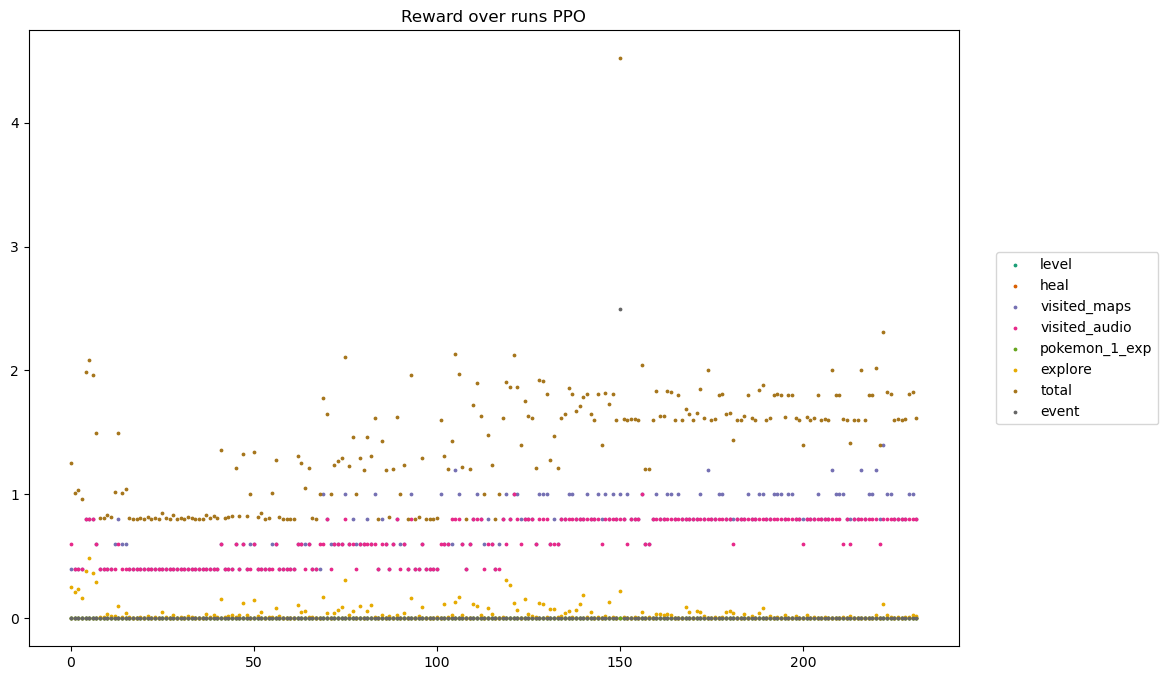

In [97]:
plot_runs(
    load_run_data(session),
    use_keys=['level', 'heal', 'visited_maps', 'visited_audio', 'pokemon_1_exp', 'explore', 'total', 'event'],
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=2,
    agg_func=np.mean
)

runs loaded: 544
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'visited_maps', 'visited_audio', 'pokemon_1_exp', 'explore', 'total']


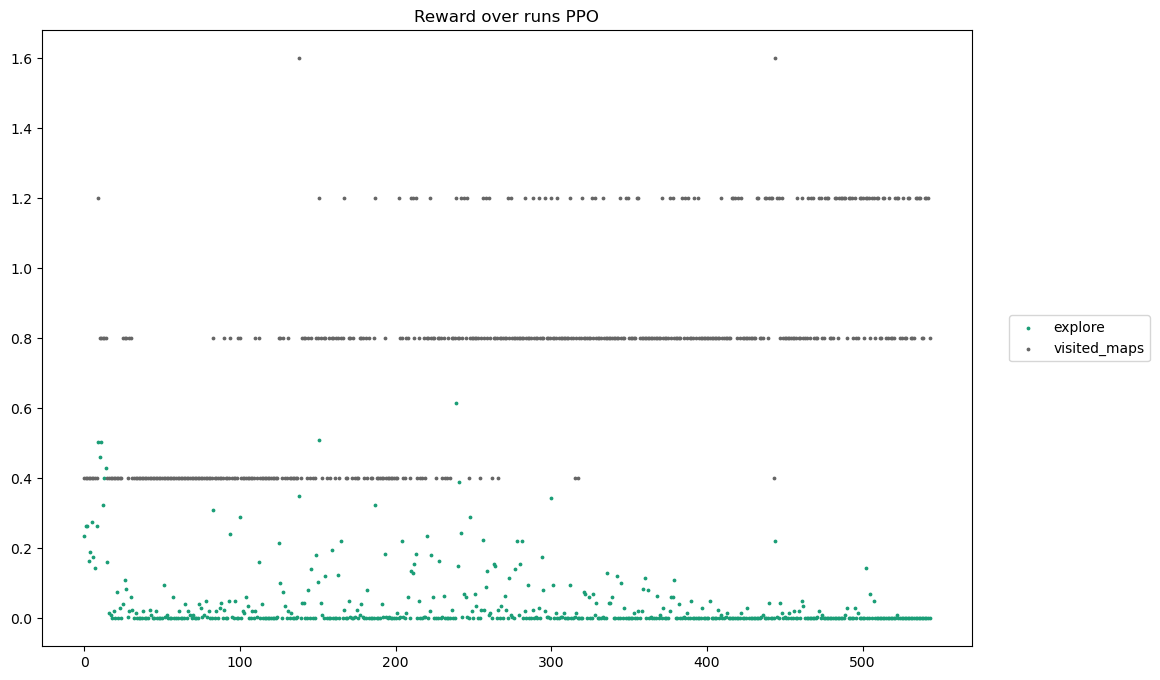

In [107]:
plot_runs(
    load_run_data(session),
    use_keys=['explore', 'visited_maps'],
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)

runs loaded: 544
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'visited_maps', 'visited_audio', 'pokemon_1_exp', 'explore', 'total']


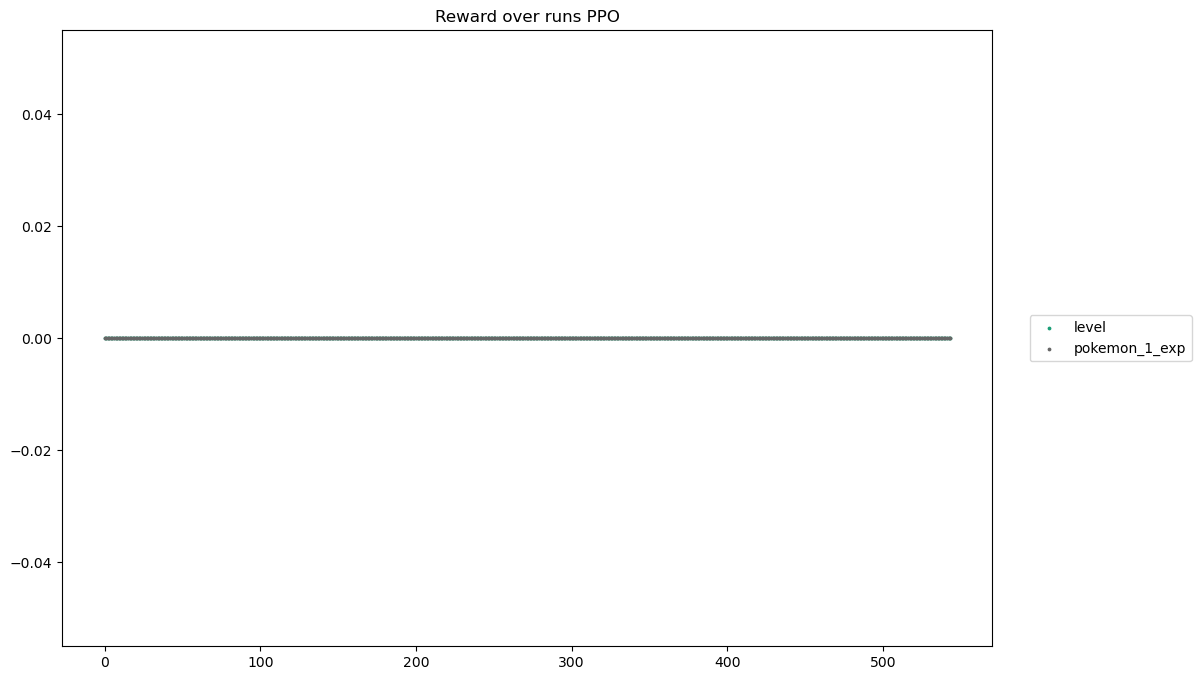

In [108]:
plot_runs(
    load_run_data(session),
    use_keys=['level', 'pokemon_1_exp'],
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)

runs loaded: 512
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'visited_maps', 'visited_audio', 'pokemon_1_exp', 'explore', 'total']


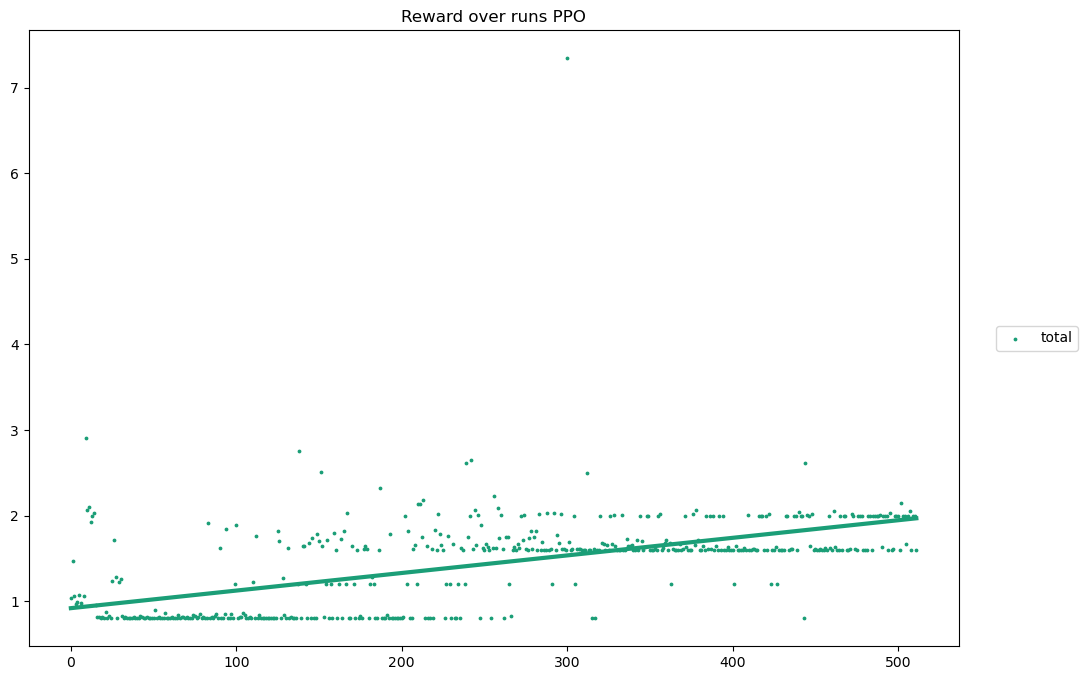

In [106]:

plot_runs(
    load_run_data(session),
    use_keys=['total'],
    plot_line=False,
    plot_fit=True,
    start=0,
    group_runs=1,
    agg_func=np.mean
)


runs loaded: 480
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


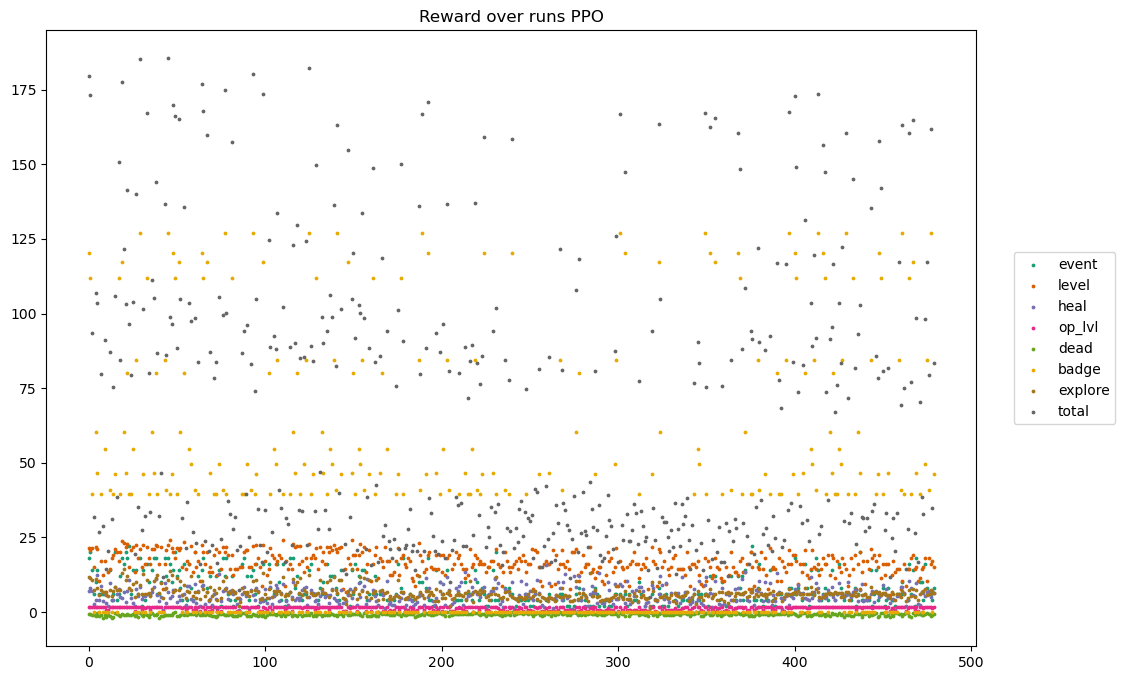

In [62]:

plot_runs(
    load_run_data(session),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)


## generate moving histograms!

In [63]:
len(load_run_data(session))

runs loaded: 480


480

In [65]:
def chunks(data, n):
    n = max(1, n)
    return [data[i:i+n] for i in range(0, len(data), n)]

In [66]:
full_dat = load_run_data(session)
for run in full_dat:
    run["total"] = sum(value for value in run.values())
full_dat_chunks = chunks(full_dat, 44)

runs loaded: 480


In [67]:
full_dat[0]

{'event': 18,
 'level': 21.375,
 'heal': 7.168035245302331,
 'op_lvl': 1.8,
 'dead': -0.6,
 'badge': 120.3312,
 'explore': 11.661999999999999,
 'total': 179.73623524530234}

In [68]:
def histo_plot(axis, stat, dat_chunks, version, compare_count):
    
    test_dat = np.array([run[stat] for run in dat_chunks[version]])
    # the histogram of the data
    n, bins, patches = axis.hist(test_dat, 10, density=False, facecolor="orange", alpha=0.95)
    
    for i in range(compare_count):
        comp_version = max(version - 1 - i, 0)
        compare_dat = np.array([run[stat] for run in dat_chunks[comp_version]])
        n, bins, patches = axis.hist(compare_dat, 10, density=False, facecolor="grey", alpha=0.2*0.25**i)

    axis.set(xlabel=f"{stat}")
    #axis.ylabel()
    # only use this title over all plots
    #axis.title()
    #plt.xlim(40, 160)
    #plt.ylim(0, 0.03)
    #axis.grid(True)
    #plt.show()

In [69]:
def plot_all(dat_chunks, version, compare_count):
    fig, axs = plt.subplots(2, 4, figsize=(16, 9), dpi=120)
    #plt.subplots_adjust(bottom=0.0, right=0.8, top=0.9)
    fig.suptitle(f"Version {version} Rewards")
    for stat, ax in zip(dat_chunks[0][0].keys(), axs.flatten()):
        histo_plot(ax, stat, dat_chunks, version, compare_count)
    return fig


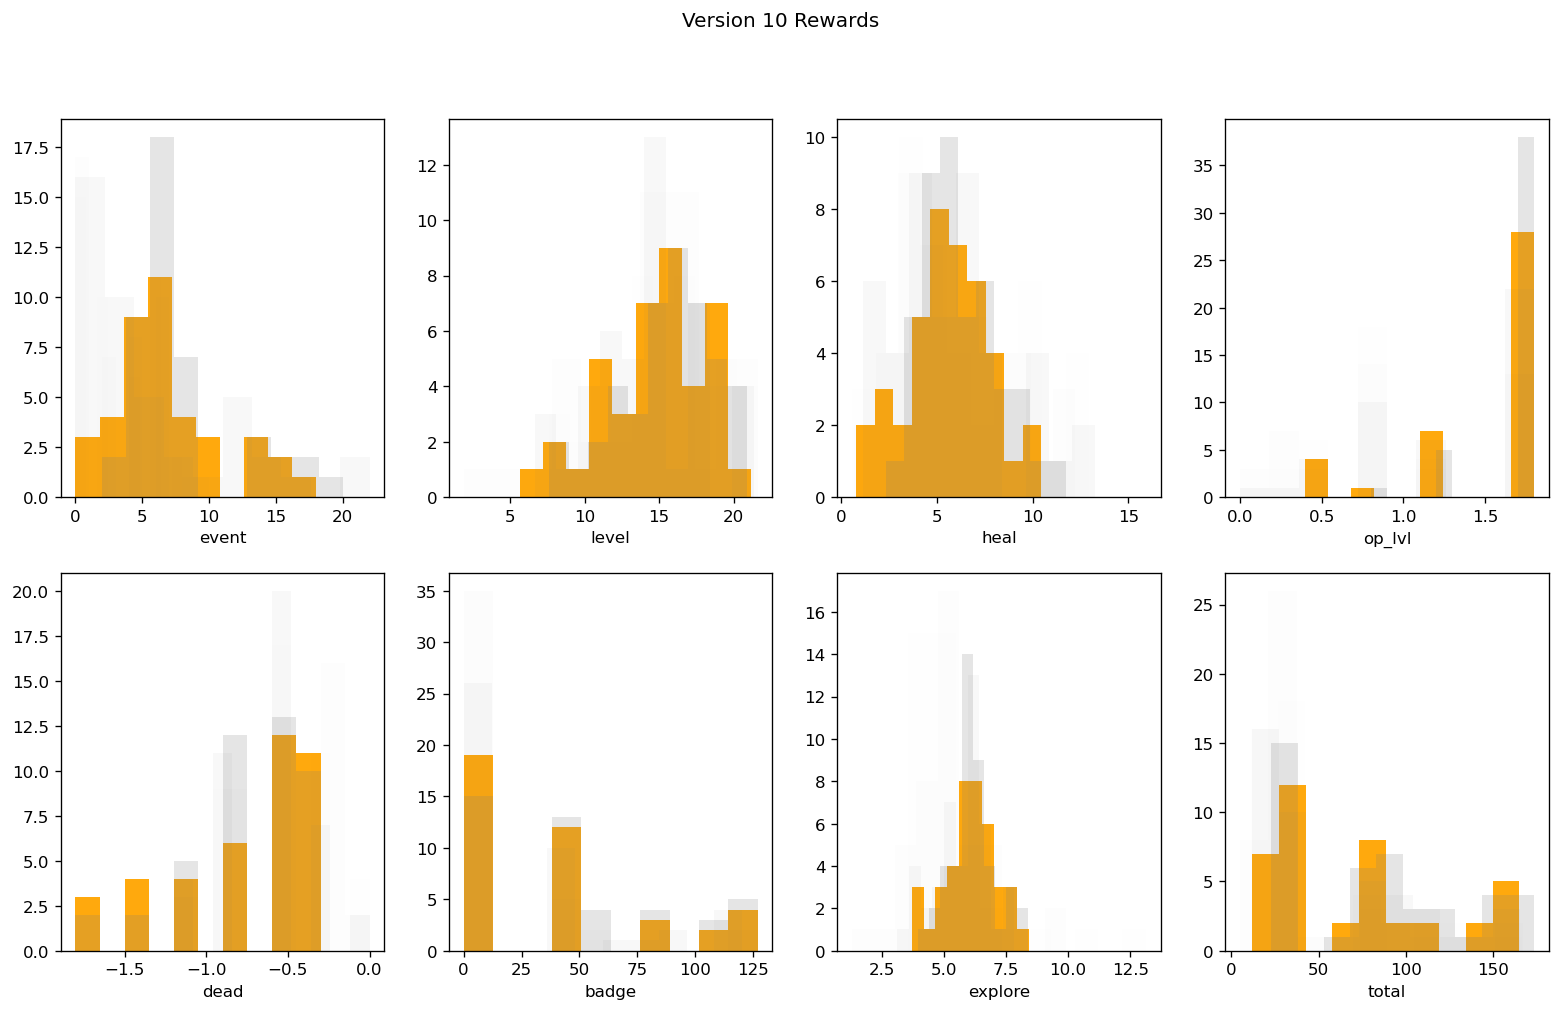

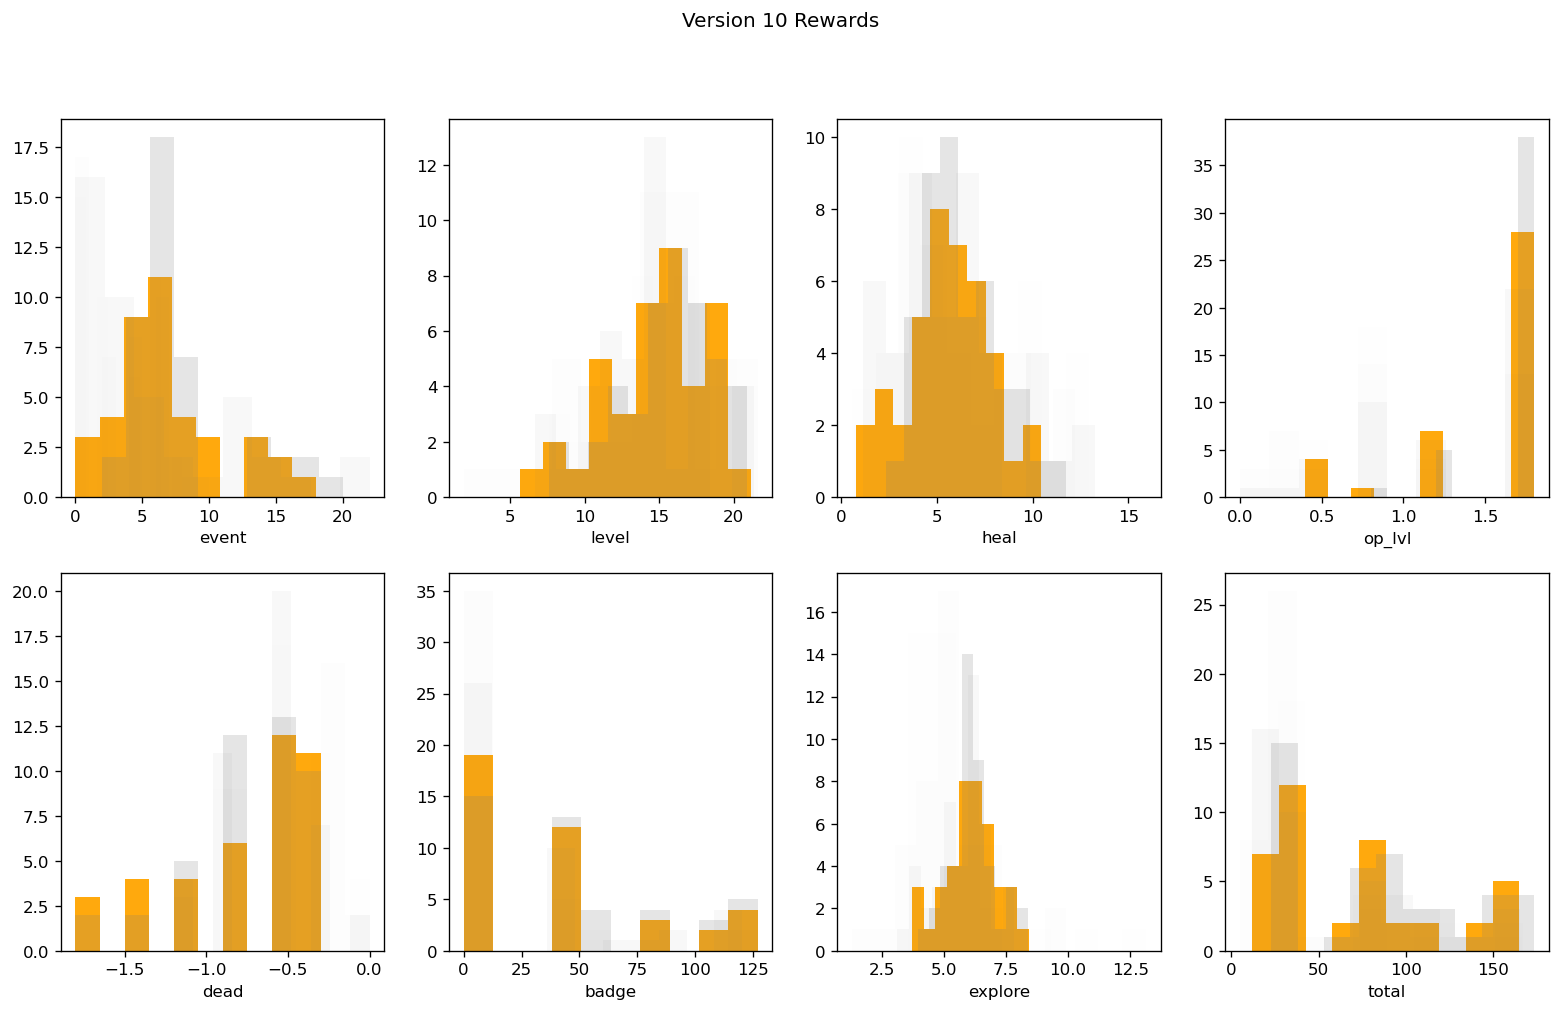

In [77]:
plot_all(chunks(full_dat, 44), 10, 5)

In [215]:
#histo_plot("level", )

In [80]:
!conda install -c anaconda ffmpeg

^C


In [81]:
with media.VideoWriter('histograms_over_time.mp4', (1080, 1920)) as wr:
    for i in tqdm(range(610)):
        #with plt.style.context('Solarize_Light2'):
        fig = plot_all(full_dat_chunks, i, 5)

        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        plt.close()

RuntimeError: Program 'ffmpeg' is not found; perhaps install ffmpeg using 'apt install ffmpeg'.